In [1]:
# Imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import utilities
import os
import time

# import data visualization
import matplotlib.pyplot as plt

# import pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD,Adam,lr_scheduler
from torch.utils.data import random_split
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [2]:
# define transformations for train
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=.40),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# define transformations for test
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# define training dataloader
def get_training_dataloader(train_transform, batch_size=128, num_workers=0, shuffle=True):
    """ return training dataloader
    Args:
        train_transform: transfroms for train dataset
        path: path to cifar100 training python dataset
        batch_size: dataloader batchsize
        num_workers: dataloader num_works
        shuffle: whether to shuffle 
    Returns: train_data_loader:torch dataloader object
    """

    transform_train = train_transform
    cifar10_training = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=transform_train)
    cifar10_training_loader = DataLoader(
        cifar10_training, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size)

    return cifar10_training_loader

# define test dataloader
def get_testing_dataloader(test_transform, batch_size=128, num_workers=0, shuffle=True):
    """ return training dataloader
    Args:
        test_transform: transforms for test dataset
        path: path to cifar100 test python dataset
        batch_size: dataloader batchsize
        num_workers: dataloader num_works
        shuffle: whether to shuffle 
    Returns: cifar100_test_loader:torch dataloader object
    """

    transform_test = test_transform
    cifar10_test = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transform_test)
    cifar10_test_loader = DataLoader(cifar10_test, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size)

    return cifar10_test_loader

In [3]:
# get dataloaders for training and testing datasets
# don't forget to turn on internet in kernel's settings
trainloader = get_training_dataloader(train_transform)
testloader = get_testing_dataloader(test_transform)

0it [00:00, ?it/s]

170500096it [00:08, 20616733.54it/s]                               


Files already downloaded and verified


In [4]:
# specify the names of the classes
classes_dict = {0 : 'airplane', 1 : 'automobile', 2: 'bird', 3 : 'cat', 4 : 'deer', 5: 'dog', 6:'frog', 7 : 'horse', 8 : 'ship', 9 : 'truck'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

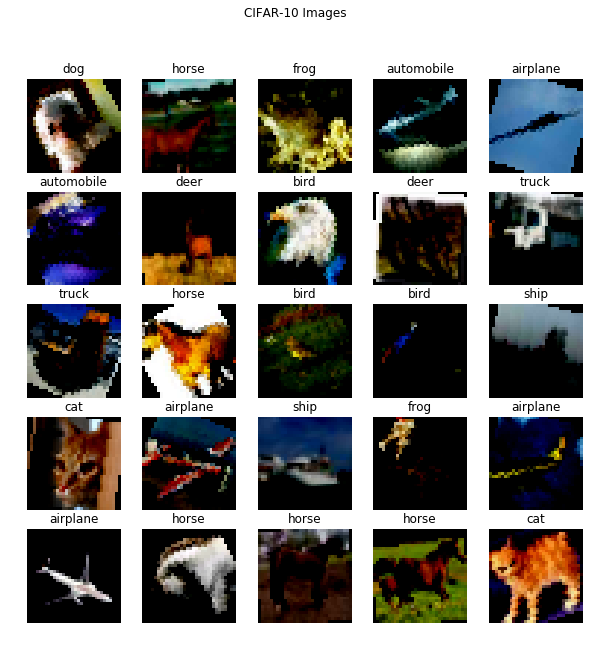

In [5]:
# plot 25 random images from training dataset
fig, axs = plt.subplots(5, 5, figsize=(10,10))
    
for batch_idx, (inputs, labels) in enumerate(trainloader):
    for im in range(25):
        image = inputs[im].permute(1, 2, 0)
        i = im // 5
        j = im % 5
        axs[i,j].imshow(image.numpy()) #plot the data
        axs[i,j].axis('off')
        axs[i,j].set_title(classes_dict[int(labels[im].numpy())])
        
    break;

# set suptitle
plt.suptitle('CIFAR-10 Images')
plt.show()

In [6]:
#"""Bottleneck layers. Although each layer only produces k
#output feature-maps, it typically has many more inputs. It
#has been noted in [37, 11] that a 1×1 convolution can be in-
#troduced as bottleneck layer before each 3×3 convolution
#to reduce the number of input feature-maps, and thus to
#improve computational efficiency."""
class Bottleneck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        #"""In  our experiments, we let each 1×1 convolution 
        #produce 4k feature-maps."""
        inner_channel = 4 * growth_rate

        #"""We find this design especially effective for DenseNet and 
        #we refer to our network with such a bottleneck layer, i.e., 
        #to the BN-ReLU-Conv(1×1)-BN-ReLU-Conv(3×3) version of H ` , 
        #as DenseNet-B."""
        self.bottle_neck = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, inner_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(inner_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(inner_channel, growth_rate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        return torch.cat([x, self.bottle_neck(x)], 1)

#"""We refer to layers between blocks as transition
#layers, which do convolution and pooling."""
class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        #"""The transition layers used in our experiments 
        #consist of a batch normalization layer and an 1×1 
        #convolutional layer followed by a 2×2 average pooling 
        #layer""".
        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)

#DesneNet-BC
#B stands for bottleneck layer(BN-RELU-CONV(1x1)-BN-RELU-CONV(3x3))
#C stands for compression factor(0<=theta<=1)
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_class=10):
        super().__init__()
        self.growth_rate = growth_rate

        #"""Before entering the first dense block, a convolution 
        #with 16 (or twice the growth rate for DenseNet-BC) 
        #output channels is performed on the input images."""
        inner_channels = 2 * growth_rate

        #For convolutional layers with kernel size 3×3, each 
        #side of the inputs is zero-padded by one pixel to keep 
        #the feature-map size fixed.
        self.conv1 = nn.Conv2d(3, inner_channels, kernel_size=3, padding=1, bias=False) 

        self.features = nn.Sequential()

        for index in range(len(nblocks) - 1):
            self.features.add_module("dense_block_layer_{}".format(index), self._make_dense_layers(block, inner_channels, nblocks[index]))
            inner_channels += growth_rate * nblocks[index]

            #"""If a dense block contains m feature-maps, we let the 
            #following transition layer generate θm output feature-
            #maps, where 0 < θ ≤ 1 is referred to as the compression 
            #fac-tor.
            out_channels = int(reduction * inner_channels) # int() will automatic floor the value
            self.features.add_module("transition_layer_{}".format(index), Transition(inner_channels, out_channels))
            inner_channels = out_channels

        self.features.add_module("dense_block{}".format(len(nblocks) - 1), self._make_dense_layers(block, inner_channels, nblocks[len(nblocks)-1]))
        inner_channels += growth_rate * nblocks[len(nblocks) - 1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('activation', nn.ReLU(inplace=True))

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.linear = nn.Linear(inner_channels, num_class)

    def forward(self, x):
        output = self.conv1(x)
        output = self.features(output)
        output = self.avgpool(output)
        output = output.view(output.size()[0], -1)
        output = self.linear(output)
        return output

    def _make_dense_layers(self, block, in_channels, nblocks):
        dense_block = nn.Sequential()
        for index in range(nblocks):
            dense_block.add_module('bottle_neck_layer_{}'.format(index), block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return dense_block

def densenet121(activation = 'relu'):
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

def densenet169(activation = 'relu'):
    return DenseNet(Bottleneck, [6,12,32,32], growth_rate=32)

def densenet201(activation = 'relu'):
    return DenseNet(Bottleneck, [6,12,48,32], growth_rate=32)

def densenet161(activation = 'relu'):
    return DenseNet(Bottleneck, [6,12,36,24], growth_rate=48)

In [7]:
# number of epochs
epochs = 50
# learning rate
learning_rate = 0.001
# device to use
# don't forget to turn on GPU on kernel's settings
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
model = densenet121()

In [9]:
# set loss function
criterion = nn.CrossEntropyLoss()

# set optimizer, only train the classifier parameters, feature parameters are frozen
optimizer = Adam(model.parameters(), lr=learning_rate)

In [10]:
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss', 'Train accuracy', 'Train top-3 accuracy','Test loss', 'Test accuracy', 'Test top-3 accuracy']) 

In [11]:
#train the model
model.to(device)

steps = 0
running_loss = 0
for epoch in range(epochs):
    
    since = time.time()
    
    train_accuracy = 0
    top3_train_accuracy = 0 
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # calculate train top-1 accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # Calculate train top-3 accuracy
        np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
        target_numpy = labels.cpu().numpy()
        top3_train_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])
        
    time_elapsed = time.time() - since
    
    test_loss = 0
    test_accuracy = 0
    top3_test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            test_loss += batch_loss.item()

            # Calculate test top-1 accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Calculate test top-3 accuracy
            np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
            target_numpy = labels.cpu().numpy()
            top3_test_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time per epoch: {time_elapsed:.4f}.. "
          f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
          f"Train loss: {running_loss/len(trainloader):.4f}.. "
          f"Train accuracy: {train_accuracy/len(trainloader):.4f}.. "
          f"Top-3 train accuracy: {top3_train_accuracy/len(trainloader):.4f}.. "
          f"Test loss: {test_loss/len(testloader):.4f}.. "
          f"Test accuracy: {test_accuracy/len(testloader):.4f}.. "
          f"Top-3 test accuracy: {top3_test_accuracy/len(testloader):.4f}")

    train_stats = train_stats.append({'Epoch': epoch, 'Time per epoch':time_elapsed, 'Avg time per step': time_elapsed/len(trainloader), 'Train loss' : running_loss/len(trainloader), 'Train accuracy': train_accuracy/len(trainloader), 'Train top-3 accuracy':top3_train_accuracy/len(trainloader),'Test loss' : test_loss/len(testloader), 'Test accuracy': test_accuracy/len(testloader), 'Test top-3 accuracy':top3_test_accuracy/len(testloader)}, ignore_index=True)

    running_loss = 0
    model.train()

Epoch 1/50.. Time per epoch: 112.2941.. Average time per step: 0.2872.. Train loss: 1.4506.. Train accuracy: 0.4649.. Top-3 train accuracy: 0.7967.. Test loss: 1.2923.. Test accuracy: 0.5354.. Top-3 test accuracy: 0.8430
Epoch 2/50.. Time per epoch: 111.8954.. Average time per step: 0.2862.. Train loss: 1.0713.. Train accuracy: 0.6136.. Top-3 train accuracy: 0.8874.. Test loss: 1.1608.. Test accuracy: 0.5989.. Top-3 test accuracy: 0.8824
Epoch 3/50.. Time per epoch: 111.8507.. Average time per step: 0.2861.. Train loss: 0.9035.. Train accuracy: 0.6780.. Top-3 train accuracy: 0.9151.. Test loss: 0.8575.. Test accuracy: 0.6960.. Top-3 test accuracy: 0.9203
Epoch 4/50.. Time per epoch: 111.8734.. Average time per step: 0.2861.. Train loss: 0.7815.. Train accuracy: 0.7238.. Top-3 train accuracy: 0.9342.. Test loss: 0.7058.. Test accuracy: 0.7578.. Top-3 test accuracy: 0.9442
Epoch 5/50.. Time per epoch: 111.7798.. Average time per step: 0.2859.. Train loss: 0.6943.. Train accuracy: 0.7572.

In [12]:
train_stats.to_csv('train_log_DenseNet121.csv')

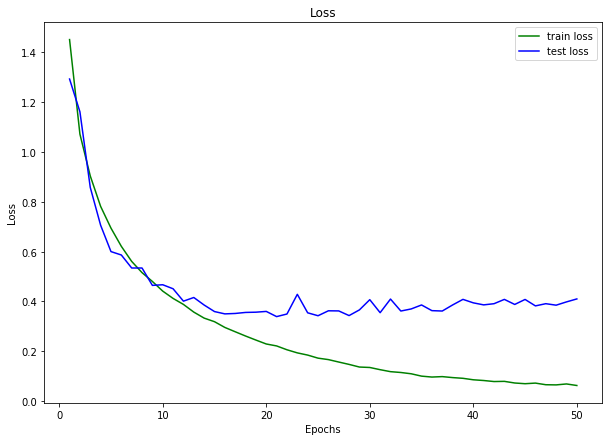

In [13]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss");

x = range(1, len(train_stats['Train loss'].values) + 1)
ax.plot(x, train_stats['Train loss'].values, '-g', label='train loss');
ax.plot(x, train_stats['Test loss'].values, '-b', label='test loss');

plt.legend()

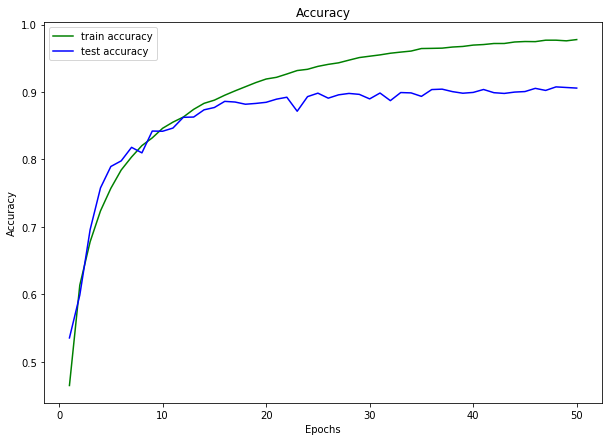

In [14]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy");

x = range(1, len(train_stats['Train accuracy'].values) + 1)
ax.plot(x, train_stats['Train accuracy'].values, '-g', label='train accuracy');
ax.plot(x, train_stats['Test accuracy'].values, '-b', label='test accuracy');

plt.legend()

In [15]:
def view_classify(img, ps, title):
    """
    Function for viewing an image and it's predicted classes
    with matplotlib.

    INPUT:
        img - (tensor) image file
        ps - (tensor) predicted probabilities for each class
        title - (str) string with true label
    """
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    image = img.permute(1, 2, 0)
    ax1.imshow(image.numpy())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(list(classes_dict.values()), size='small');
    ax2.set_title(title)
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


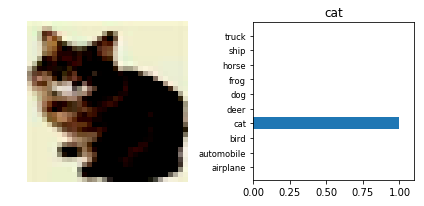

In [16]:
for batch_idx, (inputs, labels) in enumerate(testloader):
    inputs, labels = inputs.to(device), labels.to(device)
    img = inputs[0]
    label_true = labels[0]
    ps = model(inputs)
    view_classify(img.cpu(), torch.softmax(ps[0].cpu(), dim=0), classes_dict[int(label_true.cpu().numpy())])
    
    break;